In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from pathlib import Path

In [2]:
def process_df(df, metric='fpr'):
    plot_df = df[["ood_data", metric, 'detector']].copy()
    plot_df['OOD'] = plot_df["ood_data"].apply(lambda x: x.split('_')[0])

    methods = plot_df.detector.unique().tolist()
    method_df_list = []
    for m in methods:
        method_df_list.append(plot_df[plot_df.detector == m][["OOD", metric]].rename(columns={metric: m}))
    plot_df = reduce(lambda left,right: pd.merge(left,right,on=['OOD'],
                                            how='inner'), method_df_list)
    return plot_df

In [3]:
# methods = ["msp_T=None_use_xent=False", 
#            "energy_T=1.0", 
#            "odin_T=100_noise=0.005",
#            "mahalanobis_noise=0.005_layerindex=-2", 
#            "knn_K=10_layer-index=-2", 
#            "pNML_layer-index=-2", 
#            "ClassAngleMaha_layer-index=-2_rank-rtol=2e-06",
#           ]
df_std_list = [pd.read_csv(p) for p in Path("outputs/ood_eval/cifar10_densenet/").rglob("*/*.csv")]


In [4]:
# df_std_list.append(pd.read_csv("outputs/test_ood_detection/cifar10_wrn_std_spatial/ClassMaha_layer-index=-2.csv"))

In [5]:
df_std = pd.concat(df_std_list)

In [6]:
df_std.detector.unique().tolist()

['knn_K=10_layer-index=0',
 'knn_K=10_layer-index=-2',
 'odin_T=100_noise=0.005',
 'msp_T=None_use_xent=False',
 'mahalanobis_noise=0.005_layerindex=0',
 'mahalanobis_noise=0.005_layerindex=-2',
 'pNML_layer-index=-2',
 'energy_T=1.0',
 'ClassAngleMaha_layer-index=-2_rank-rtol=2e-06_class_',
 'ClassAngleMaha_layer-index=-2_rank-rtol=2e-06_non-class_add-bg-score',
 'ClassAngleMaha_layer-index=-2_rank-rtol=2e-06_class_add-bg-score']

In [7]:
print_order_dict = {
    'msp': 0,
    'energy': 1,
    'odin': 2,
    'mahalanobis': 3,
    'ClassAngleMaha': 4,
    'knn': 5,
    'pNML': 6,
} 
df_std["print_order"] = df_std.detector.apply(lambda name: print_order_dict[name.split("_")[0]])
df_std = df_std.sort_values(by="print_order")

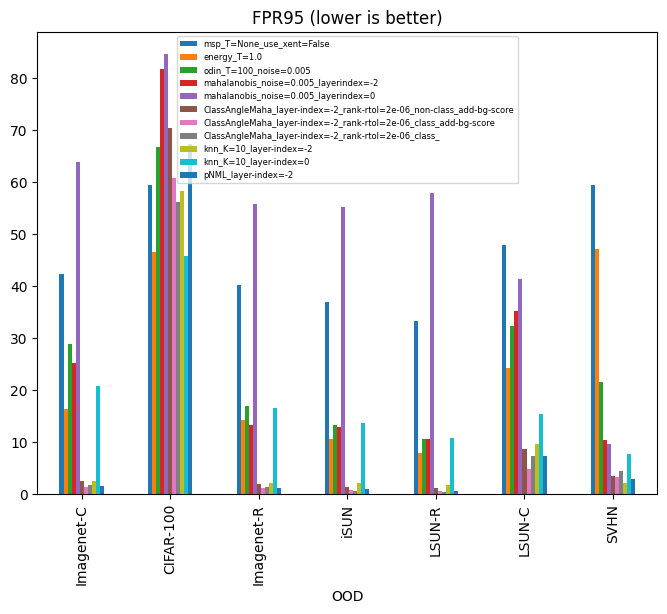

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
process_df(df_std, metric='fpr').plot(kind='bar', x="OOD",  title="FPR95 (lower is better)", ax=axes)
plt.legend(loc='upper center', prop={'size': 6})

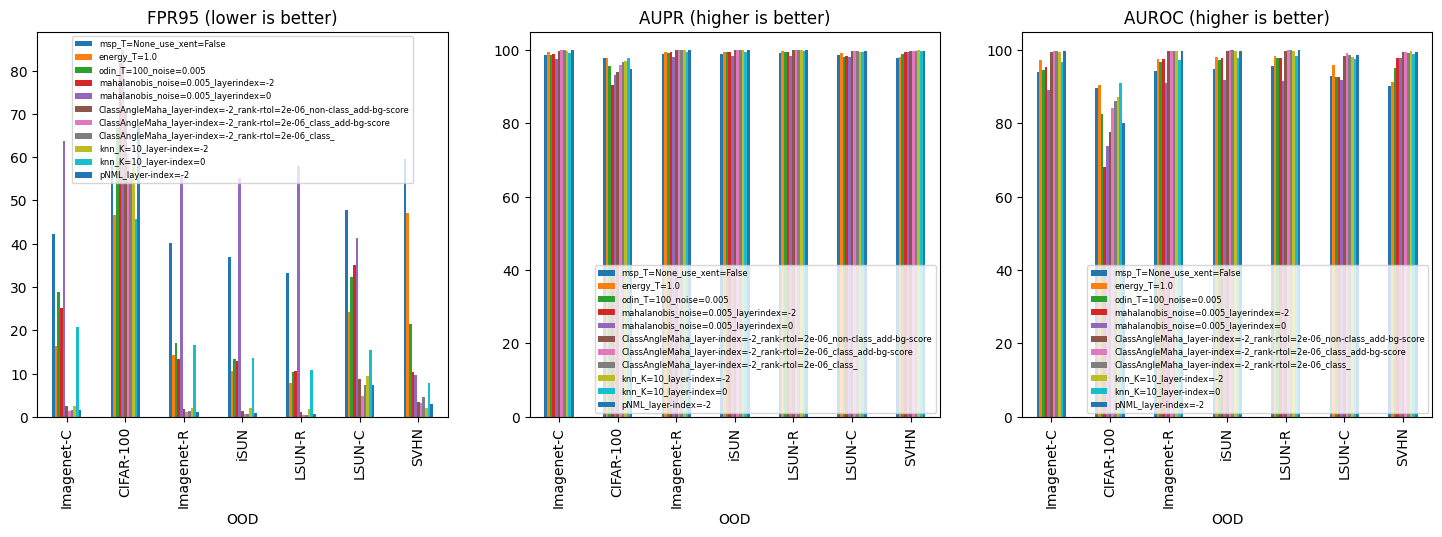

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
process_df(df_std, metric='fpr').plot(kind='bar', x="OOD",  title="FPR95 (lower is better)", ax=axes[0])
axes[0].legend(loc='upper center', prop={'size': 6})
process_df(df_std, metric='aupr').plot(kind='bar', x="OOD",  title="AUPR (higher is better)", ax=axes[1])
axes[1].legend(loc='lower right', prop={'size': 6})
process_df(df_std, metric='auroc').plot(kind='bar', x="OOD",  title="AUROC (higher is better)", ax=axes[2])
axes[2].legend(loc='lower right', prop={'size': 6})

In [11]:
scores = ["fpr", "auroc"]
# ood_datas = df_std.ood_data.unique()
ood_datas =  ['SVHN', 'LSUN-C', 'LSUN-R', 'iSUN', 'Imagenet-R', 'Imagenet-C'] #, 'CIFAR-100']
cols = [f"{d}_{s}" for d in ood_datas for s in scores]
cols.insert(0, "method")

# print_df = pd.DataFrame(columns=cols)

data = []
for det in df_std.detector.unique():
    temp_df = df_std[df_std.detector == det].set_index("ood_data")
    r = [det, ]
    for d in ood_datas:
        for s in scores:
            r.append(temp_df[s][d])
    data.append(r)

print_df = pd.DataFrame(columns=cols, data=data)
# print_df = print_df.set_index('method')
print_df.columns=pd.MultiIndex.from_tuples([x.split('_')[:] for x in print_df.columns])
print_df = print_df.set_index('method')
# Print df_std.detector.unique() then paste here
print_df.index = print_df.index.map(lambda x: x[0])
print_df = print_df.filter(items=[
                'msp_T=None_use_xent=False',
                'energy_T=1.0',
                'odin_T=100_noise=0.005',
                'mahalanobis_noise=0.005_layerindex=0',
                'ClassAngleMaha_layer-index=-2_rank-rtol=2e-06',
                'ClassAngleMaha_layer-index=-2_rank-rtol=2e-06_non-class_add-bg-score',
                'ClassAngleMaha_layer-index=-2_rank-rtol=2e-06_class_',
                'ClassAngleMaha_layer-index=-2_rank-rtol=2e-06_class_add-bg-score',
                'knn_K=10_layer-index=-2',
                'pNML_layer-index=-2',
            ], axis='index')
print_df.index = print_df.index.map(lambda x: 'ClassAngleMaha (Bg)' if x == 'ClassAngleMaha_layer-index=-2_rank-rtol=2e-06_non-class_add-bg-score' else x)
print_df.index = print_df.index.map(lambda x: 'ClassAngleMaha (Cls+Bg)' if x == 'ClassAngleMaha_layer-index=-2_rank-rtol=2e-06_class_add-bg-score' else x)
print_df.index = print_df.index.map(lambda x: 'ClassAngleMaha (Cls)' if x == 'ClassAngleMaha_layer-index=-2_rank-rtol=2e-06_class_' else x)
print_df.index = print_df.index.map(lambda x: x.split('_')[0])

print_df


# print_df = df_std[(df_std.detector == "odin_T=100_noise=0.005") & (df_std.ood_data.isin(["SVHN", "iSUN", "LSUN-R", "Imagenet-R"]))][["ood_data", "auroc", "fpr"]].set_index("ood_data")

SVHN            LSUN-C            LSUN-R             \
                           fpr      auroc    fpr      auroc    fpr      auroc   
method                                                                          
msp                      59.54  90.065780  47.86  92.877829  33.30  95.420550   
energy                   47.12  91.158098  24.26  95.934468   7.77  98.379771   
odin                     21.48  94.957842  32.28  92.457387  10.47  97.661506   
mahalanobis               9.68  97.809834  41.37  91.766665  57.92  91.573981   
ClassAngleMaha (Bg)       3.45  99.219351   8.71  98.362360   1.17  99.662859   
ClassAngleMaha (Cls)      4.49  98.985480   7.28  98.564896   0.40  99.849051   
ClassAngleMaha (Cls+Bg)   3.29  99.309742   4.80  98.985900   0.50  99.843824   
knn                       2.15  99.577721   9.53  98.073337   1.70  99.616516   
pNML                      2.93  99.316942   7.35  98.642548   0.62  99.763362   

                          iSUN            Imagenet-R            Imagenet-C  \
                           fpr      auroc        fpr      auroc        fpr   
method                                                                       
msp                      36.87  94.778997      40.28  94.209830      42.31   
energy                   10.62  98.012395      14.29  97.423725      16.40   
odin                     13.34  97.206079      16.97  96.536426      28.78   
mahalanobis              55.19  91.660956      55.80  90.996188      63.83   
ClassAngleMaha (Bg)       1.25  99.644503       1.92  99.568081       2.54   
ClassAngleMaha (Cls)      0.61  99.815526       1.27  99.686224       1.62   
ClassAngleMaha (Cls+Bg)   0.69  99.817630       1.15  99.730949       1.31   
knn                       2.14  99.495624       2.10  99.544068       2.54   
pNML                      0.98  99.706813       1.07  99.687793       1.47   

                                    
                             auroc  
method                              
msp                      93.932798  
energy                   97.058585  
odin                     94.343182  
mahalanobis              88.991521  
ClassAngleMaha (Bg)      99.382584  
ClassAngleMaha (Cls)     99.555192  
ClassAngleMaha (Cls+Bg)  99.627892  
knn                      99.405947  
pNML                     99.522734

In [12]:
styler = print_df.style
styler.format(precision=2)
styler.highlight_max(subset=pd.IndexSlice[:, pd.IndexSlice[:, 'auroc']], props='bfseries:;')
styler.highlight_min(subset=pd.IndexSlice[:, pd.IndexSlice[:, 'fpr']], props='bfseries:;')
df_tex = styler.to_latex(
    caption="CIFAR-100 as ID, Dense net.",
    # clines="skip-last;data",
    # convert_css=True,
    position_float="centering",
    multicol_align="|c|",
    hrules=True,)
print(df_tex)

\begin{table}
\centering
\caption{CIFAR-100 as ID, Dense net.}
\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{2}{|c|}{SVHN} & \multicolumn{2}{|c|}{LSUN-C} & \multicolumn{2}{|c|}{LSUN-R} & \multicolumn{2}{|c|}{iSUN} & \multicolumn{2}{|c|}{Imagenet-R} & \multicolumn{2}{|c|}{Imagenet-C} \\
 & fpr & auroc & fpr & auroc & fpr & auroc & fpr & auroc & fpr & auroc & fpr & auroc \\
method &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
msp & 59.54 & 90.07 & 47.86 & 92.88 & 33.30 & 95.42 & 36.87 & 94.78 & 40.28 & 94.21 & 42.31 & 93.93 \\
energy & 47.12 & 91.16 & 24.26 & 95.93 & 7.77 & 98.38 & 10.62 & 98.01 & 14.29 & 97.42 & 16.40 & 97.06 \\
odin & 21.48 & 94.96 & 32.28 & 92.46 & 10.47 & 97.66 & 13.34 & 97.21 & 16.97 & 96.54 & 28.78 & 94.34 \\
mahalanobis & 9.68 & 97.81 & 41.37 & 91.77 & 57.92 & 91.57 & 55.19 & 91.66 & 55.80 & 91.00 & 63.83 & 88.99 \\
ClassAngleMaha (Bg) & 3.45 & 99.22 & 8.71 & 98.36 & 1.17 & 99.66 & 1.25 & 99.64 & 1.92 & 99.57 & 2.54 & 99.38 \\
ClassAngleMaha (Cls) & 4.